#### 基于openai gym CliffWalking学习QLearning算法，本节均在此记事本下进行代码注释和修改
注意CliffWalking环境是model-based，即P(s'|s,a)和R(s,a)是已知的

笔记地址 https://blog.csdn.net/weixin_43868436/article/details/123763350 

原代码gym版本为 0.21.0 为了方便查看github源码，采用0.23.1版本，因此会有一些警告 


In [1]:
import sys
from pathlib import Path
curr_path = str(Path().absolute())
parent_path = str(Path().absolute().parent)
sys.path.append(parent_path) # 添加路径到系统路径

import gym
import torch
import math
import datetime
import numpy as np
from collections import defaultdict
from envs.gridworld_env import CliffWalkingWapper
from QLearning.agent import QLearning
from common.utils import plot_rewards
from common.utils import save_results,make_dir


D:\code\Anaconda3\envs\gym\lib\site-packages\matplotlib_inline\config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):
D:\code\Anaconda3\envs\gym\lib\site-packages\seaborn\rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
D:\code\Anaconda3\envs\gym\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


## QLearning算法

In [2]:
class QLearning(object):
    def __init__(self,state_dim,
                 action_dim,cfg):
        self.action_dim = action_dim 
        self.lr = cfg.lr  # 学习率
        self.gamma = cfg.gamma  
        self.epsilon = 0 
        self.sample_count = 0  
        self.epsilon_start = cfg.epsilon_start
        self.epsilon_end = cfg.epsilon_end
        self.epsilon_decay = cfg.epsilon_decay
        self.Q_table  = defaultdict(lambda: np.zeros(action_dim)) # 用嵌套字典存放状态->动作->状态-动作值（Q值）的映射，即Q表。key为state,value为4维向量，代表四个动作的Q值。 lambda为匿名函数，如果dict中没有对应的key，则返回默认值np.zeros(4)
    
    def choose_action(self, state):
        '''训练时，使用行为策略选择动作'''
        self.sample_count += 1
        self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
            math.exp(-1. * self.sample_count / self.epsilon_decay) # epsilon是会递减的，这里选择指数递减
        # e-greedy 策略
        if np.random.uniform(0, 1) > self.epsilon:
            action = np.argmax(self.Q_table[str(state)]) # 选择Q(s,a)最大对应的动作
        else:
            action = np.random.choice(self.action_dim) # 随机选择动作
        return action
    
    def predict(self,state):
        '''测试时，使用学习到的目标策略选择动作'''
        action = np.argmax(self.Q_table[str(state)])
        return action
    
    def update(self, state, action, reward, next_state, done):
        '''每走一步更新一次'''
        Q_predict = self.Q_table[str(state)][action] 
        if done: # 终止状态 根据公式只有r
            Q_target = reward
        else:
            # 更新时使用目标策略选择最佳动作，使得Q(s',a)最大
            Q_target = reward + self.gamma * np.max(self.Q_table[str(next_state)]) 
        self.Q_table[str(state)][action] += self.lr * (Q_target - Q_predict)

    def save(self,path):
        '''保存QLearning学习到的表格Q_table'''
        import dill
        torch.save(
            obj=self.Q_table,
            f=path+"Qleaning_model.pkl",
            pickle_module=dill
        )
        print("保存模型成功！")

    def load(self, path):
        '''导入学习到的Q_table表格,用来测试'''
        import dill
        self.Q_table =torch.load(f=path+'Qleaning_model.pkl',pickle_module=dill)
        print("加载模型成功！")


def train(cfg,env,agent):
    print('开始训练!')
    print(f'环境：{cfg.env_name}, 算法：{cfg.algo_name}, 设备：{cfg.device}')
    rewards = []  # 记录奖励
    ma_rewards = [] # 记录滑动平均奖励
    for i_ep in range(cfg.train_eps):
        ep_reward = 0  # 记录每个episode的reward。 reward大小只是评价策略的好坏，没有实际意义
        state = env.reset()  # 重置环境, 重新开一局（即开始新的一个episode）
        while True:
            if cfg.show:
                env.render()
            action = agent.choose_action(state)  # 根据算法选择一个动作
            # 在model-free的情况下，R(s,a)是未知的。但本问题是model-based，知道采取action后到达的新状态（移动到的相邻状态）以及R（在这里新状态如果是悬崖则R=-100，否则为-1）
            next_state, reward, done, _ = env.step(action)  # 与环境进行一次动作交互
            agent.update(state, action, reward, next_state, done)  # Q-learning算法更新
            state = next_state  # 存储上一个观察值
            ep_reward += reward
            if done:
                break
        rewards.append(ep_reward)
        if ma_rewards:
            ma_rewards.append(ma_rewards[-1]*0.9+ep_reward*0.1)
        else:
            ma_rewards.append(ep_reward)
        if (i_ep+1)%20 == 0: 
            print('回合：{}/{}, 奖励：{}'.format(i_ep+1, cfg.train_eps, ep_reward))
    env.close()
    print('完成训练！')
    return rewards,ma_rewards


def test(cfg,env,agent):
    # env = gym.make("FrozenLake-v0", is_slippery=False)  # 0 left, 1 down, 2 right, 3 up
    # env = FrozenLakeWapper(env)
    print('开始测试!')
    print(f'环境：{cfg.env_name}, 算法：{cfg.algo_name}, 设备：{cfg.device}')
    # 由于测试不需要使用epsilon-greedy策略，所以相应的值设置为0
    cfg.epsilon_start = 0.0 # e-greedy策略中初始epsilon
    cfg.epsilon_end = 0.0 # e-greedy策略中的终止epsilon
    rewards = [] # 记录所有回合的奖励
    ma_rewards = []  # 记录所有回合的滑动平均奖励
    for i_ep in range(cfg.test_eps):
        ep_reward = 0  # 记录每个episode的reward
        state = env.reset()  # 重置环境, 重新开一局（即开始新的一个episode）
        while True:
            # 显示图形界面 装饰前的render函数是打印字符到文本
            if cfg.show:
                env.render()
            action = agent.predict(state)  # 根据算法选择一个动作
            next_state, reward, done, _ = env.step(action)  # 与环境进行一个交互
            state = next_state  # 存储上一个观察值
            ep_reward += reward
            if done:
                break
        rewards.append(ep_reward)
        if ma_rewards:
            ma_rewards.append(ma_rewards[-1]*0.9+ep_reward*0.1)
        else:
            ma_rewards.append(ep_reward)
        print(f"回合：{i_ep+1}/{cfg.test_eps}，奖励：{ep_reward:.1f}")
    # 关闭图形界面
    env.close()
    print('完成测试！')
    return rewards,ma_rewards

## 设置参数

In [3]:
curr_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # 获取当前时间
algo_name = 'Q-learning'  # 算法名称
env_name = 'CliffWalking-v0'  # 环境名称
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 检测GPU
class QlearningConfig:
    '''训练相关参数'''
    def __init__(self):
        self.algo_name = algo_name # 算法名称
        self.env_name = env_name # 环境名称
        self.device = device # 检测GPU
        self.train_eps = 400 # 训练的回合数 (400不一定能收敛，可以设置更大些)
        self.test_eps = 20 # 测试的回合数
        self.gamma = 0.9 # reward的衰减率
        self.epsilon_start = 0.95 # e-greedy策略中初始epsilon e为随机选择操作的概率
        self.epsilon_end = 0.01 # e-greedy策略中的终止epsilon
        self.epsilon_decay = 300 # e-greedy策略中epsilon的衰减率
        self.lr = 0.1 # 学习率
        self.show = False # 训练过程使用render可视化


class PlotConfig:
    ''' 绘图相关参数设置'''
    def __init__(self) -> None:
        self.algo_name = algo_name  # 算法名称
        self.env_name = env_name  # 环境名称
        self.device = device # 检测GPU
        self.result_path = curr_path + "/outputs/" + self.env_name + \
            '/' + curr_time + '/results/'  # 保存结果的路径
        self.model_path = curr_path + "/outputs/" + self.env_name + \
            '/' + curr_time + '/models/'  # 保存模型的路径
        self.save = True  # 是否保存图片


def env_agent_config(cfg,seed=1):
    '''创建环境和智能体
    Args:
        cfg ([type]): [description]
        seed (int, optional): 随机种子. Defaults to 1.
    Returns:
        env [type]: 环境
        agent : 智能体
    '''    
    env = gym.make(cfg.env_name)
    # 使用装饰器对可视化函数render进行重写，环境中其他定义和gym源码一致
    env = CliffWalkingWapper(env)
    env.seed(seed) # 设置随机种子
    state_dim = env.observation_space.n # 状态维度 48
    action_dim = env.action_space.n # 动作维度 4
    agent = QLearning(state_dim,action_dim,cfg)
    return env,agent

## 执行训练并输出结果

D:\code\Anaconda3\envs\gym\lib\site-packages\gym\core.py:173: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  "Function `env.seed(seed)` is marked as deprecated and will be removed in the future. "


开始训练!
环境：CliffWalking-v0, 算法：Q-learning, 设备：cuda
回合：20/400, 奖励：-107
回合：40/400, 奖励：-41
回合：60/400, 奖励：-37
回合：80/400, 奖励：-39
回合：100/400, 奖励：-24
回合：120/400, 奖励：-51
回合：140/400, 奖励：-14
回合：160/400, 奖励：-122
回合：180/400, 奖励：-24
回合：200/400, 奖励：-27
回合：220/400, 奖励：-22
回合：240/400, 奖励：-14
回合：260/400, 奖励：-15
回合：280/400, 奖励：-15
回合：300/400, 奖励：-15
回合：320/400, 奖励：-13
回合：340/400, 奖励：-18
回合：360/400, 奖励：-13
回合：380/400, 奖励：-15
回合：400/400, 奖励：-13
完成训练！
保存模型成功！
结果保存完毕！


D:\code\Anaconda3\envs\gym\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
D:\code\Anaconda3\envs\gym\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


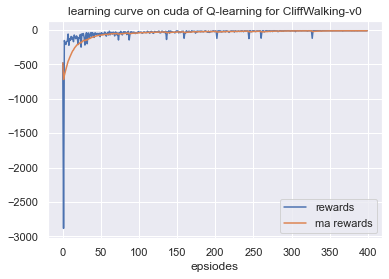

加载模型成功！
开始测试!
环境：CliffWalking-v0, 算法：Q-learning, 设备：cuda
回合：1/20，奖励：-13.0
回合：2/20，奖励：-13.0
回合：3/20，奖励：-13.0
回合：4/20，奖励：-13.0
回合：5/20，奖励：-13.0
回合：6/20，奖励：-13.0
回合：7/20，奖励：-13.0
回合：8/20，奖励：-13.0
回合：9/20，奖励：-13.0
回合：10/20，奖励：-13.0
回合：11/20，奖励：-13.0
回合：12/20，奖励：-13.0
回合：13/20，奖励：-13.0
回合：14/20，奖励：-13.0
回合：15/20，奖励：-13.0
回合：16/20，奖励：-13.0
回合：17/20，奖励：-13.0
回合：18/20，奖励：-13.0
回合：19/20，奖励：-13.0
回合：20/20，奖励：-13.0
完成测试！
结果保存完毕！


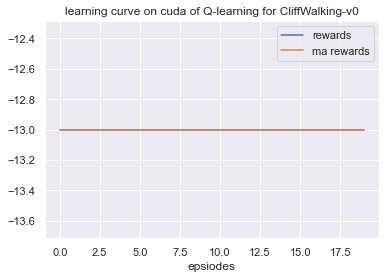

In [4]:
cfg = QlearningConfig()
plot_cfg = PlotConfig()
# 训练
env, agent = env_agent_config(cfg, seed=1)
rewards, ma_rewards = train(cfg, env, agent)
make_dir(plot_cfg.result_path, plot_cfg.model_path)  # 创建保存结果和模型路径的文件夹
agent.save(path=plot_cfg.model_path)  # 保存模型
save_results(rewards, ma_rewards, tag='train',
            path=plot_cfg.result_path)  # 保存结果
plot_rewards(rewards, ma_rewards, plot_cfg, tag="train")  # 画出结果
# 测试
env, agent = env_agent_config(cfg, seed=10)
agent.load(path=plot_cfg.model_path)  # 导入模型 为angent.Q_table赋值
rewards, ma_rewards = test(cfg, env, agent)
save_results(rewards, ma_rewards, tag='test', path=plot_cfg.result_path)  # 保存结果
plot_rewards(rewards, ma_rewards, plot_cfg, tag="test")  # 画出结果